In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
%matplotlib inline

In [3]:
df_train = pd.read_csv("../data/train_new.csv")
print('Number of train records: {}'.format(len(df_train)))
df_train.head()

Number of train records: 60000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.038835,0,0,0,0,1,2461.419769,2334.161163,2,67.0,...,1,0,0,0,0,0,0,0,0,1
1,0.504854,0,0,0,1,0,2371.483467,2341.480947,2,92.0,...,0,1,0,0,0,0,1,0,0,0
2,0.529126,0,0,0,1,1,2465.059892,2429.073831,7,67.0,...,1,0,0,0,0,1,0,0,0,0
3,0.033981,0,0,1,0,0,2419.540115,2635.040637,9,149.0,...,0,0,1,0,0,0,1,0,0,0
4,0.533981,0,0,1,0,1,2479.255239,2173.943626,7,68.0,...,1,0,0,0,0,1,0,0,0,0


In [4]:
df_test = pd.read_csv("../data/test_new.csv")
print('Number of test records: {}'.format(len(df_test)))
df_test.head()

Number of test records: 30000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.970874,1,0,1,1,1,2624.520690,2379.499974,7,121.0,...,0,0,0,1,0,0,0,0,1,0
1,0.524272,0,1,1,1,0,2524.058532,2615.882473,6,100.0,...,0,1,0,0,0,0,0,1,0,0
2,1.000000,0,1,1,0,0,2696.577167,2567.505982,2,91.0,...,0,1,0,0,0,0,0,0,0,1
3,0.033981,0,0,0,0,1,2515.834726,2821.948226,6,74.0,...,1,0,0,0,0,0,0,0,0,1
4,0.495146,0,0,0,0,1,2609.989756,2282.274343,7,121.0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
# print(df_train.columns)
cols = ['rent_approval_date', 
        'town_0', 'town_1', 'town_2', 'town_3', 'town_4', #for binary encoding
#         'town', #for target encoding 
       'flat_model', 
       #'floor_area_sqm', 
       'lease_commence_date',
       #'avg_stock_price', 
        'num_shopping_malls', 
        'min_distance',
       'avg_coe_price', 
        'num_primary_schools', 
       'min_distance_planned',
       'flat_type_3-room', 'flat_type_4-room', 'flat_type_executive', 'flat_type_5-room', 'flat_type_2-room',
       'central region', 'east region', 'north region', 'north-east region', 'west region',
       'subzone', 
        'latitude', 'longitude', 
       # 'furnished', 'elevation',
        'planning_area_0' ,'planning_area_1' ,'planning_area_2' ,'planning_area_3' , 'planning_area_4', 
       # 'street_name', 
        'block'
       ]

y_train = df_train['monthly_rent'].values
X_train = df_train[cols].values

X_test = df_test[cols].values

# Gradient Boosting with SKLearn

### Use HistGradientBoostingRegressor since it's much faster for large dataset

MAE: -365.590 (4.765)
30000
[3202, 2755, 3576, 1990, 2674]


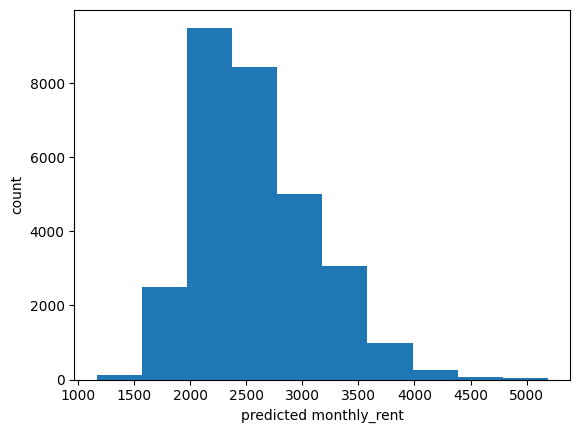

CPU times: user 2.59 s, sys: 1.46 s, total: 4.05 s
Wall time: 5.45 s


In [6]:
%%time
categorical_features = []

model = HistGradientBoostingRegressor( loss='gamma',
                                        learning_rate=0.13, 
                                        max_depth=None,
                                        max_bins=255,
                                        categorical_features=categorical_features,
                                        random_state=237,
                                        l2_regularization=2.9) 

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

In [7]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.to_csv("../data/gb_output_sklearn.csv", index_label='Id')

# Gradient Boosting with XGBoost

MAE: -365.035 (4.781)
30000
[3268, 2760, 3526, 1984, 2702]


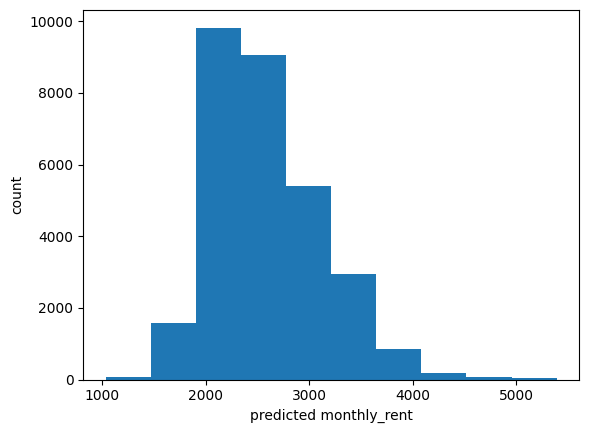

CPU times: user 3.35 s, sys: 278 ms, total: 3.63 s
Wall time: 45.3 s


In [8]:
%%time


model = XGBRegressor(objective ='reg:squarederror', alpha = 14, eta=0.11, max_depth=6, subsample=0.93)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

In [9]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.to_csv("../data/gb_output_xgboost.csv", index_label='Id')

# Gradient Boosting with CatBoost

MAE: -365.350 (4.751)
30000
[3280, 2688, 3549, 1951, 2685]


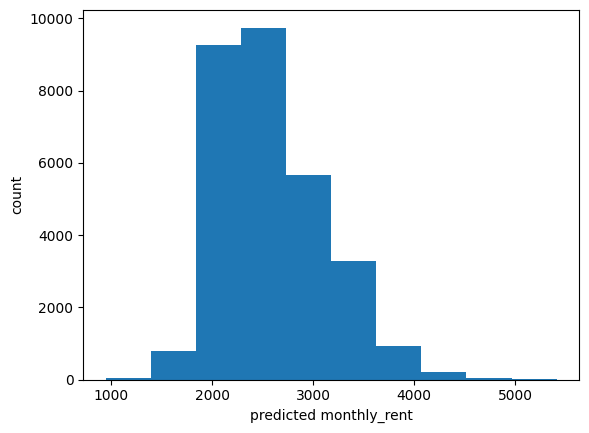

CPU times: user 6.96 s, sys: 623 ms, total: 7.58 s
Wall time: 43.3 s


In [17]:
%%time
model = CatBoostRegressor(verbose=0, n_estimators=255)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

In [11]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.to_csv("../data/gb_output_catboost.csv", index_label='Id')

# Gradient Boosting with LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 32
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 32
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data p

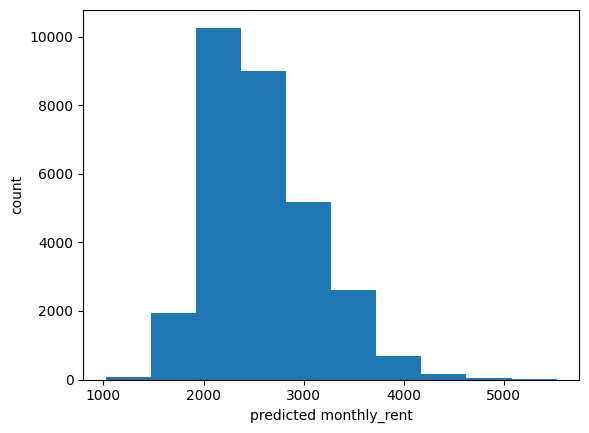

CPU times: user 3min 39s, sys: 498 ms, total: 3min 39s
Wall time: 14.3 s


In [15]:
%%time
params = {
    "objective": "regression",
    "metric": "mse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
}

train_data = lgb.Dataset(X_train, label=y_train)
num_round = 1000
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=num_round,
    nfold=10,
    stratified=False,
)

best_round = len(cv_results["valid l2-mean"])
model = lgb.train(params, train_data, num_boost_round=best_round)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

In [13]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.to_csv("../data/gb_output_lightgbm.csv", index_label='Id')